In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline

In [2]:
class Move():
    def __init__(self, axis, level, rotation):
        self.axis = axis
        self.level = level
        self.rotation = rotation
        
    def invert(self):
        return Move(self.axis, self.level, 1 - self.rotation)

In [58]:
class ComponentCube():
    def __init__(self, position, orientation):
        self.position = position
        self.orientation = orientation
        
        self.rotation_mapping = {
            'x': {'f': 't', 't': 'k', 'k': 'b', 'b': 'f', 'l': 'l', 'r': 'r'},
            'y': {'f': 'l', 'l': 'k', 'k': 'r', 'r': 'f', 't': 't', 'b': 'b'},
            'z': {'t': 'l', 'l': 'b', 'b': 'r', 'r': 't', 'f': 'f', 'k': 'k'}
        }
        
        self.position_mapping = {
            '[2, 1]': [1, 0],
            '[1, 0]': [0, 1],
            '[0, 1]': [1, 2],
            '[1, 2]': [2, 1],
            '[0, 0]': [0, 2],
            '[0, 2]': [2, 2],
            '[2, 2]': [2, 0],
            '[2, 0]': [0, 0],
            '[1, 1]': [1, 1]
        }
        
        self.projections = {
            'x': [1, 2],
            'y': [2, 0],
            'z': [0, 1]
        }
    
    def make_move(self, move: Move):
        num_rotations = int(4 * move.rotation)
        assert num_rotations in [1, 2, 3]
        for i in range(num_rotations):
            self.get_new_orientation(move)
            self.get_new_position(move)
            
    def get_new_orientation(self, move: Move):
        self.orientation = {k: self.orientation[v] for k, v in self.rotation_mapping[move.axis].items()}
            
    def get_new_position(self, move: Move):
        position_copy = self.position.copy()
        projection = self.projections[move.axis]
        projection_coords = [position_copy[projection[0]], position_copy[projection[1]]]
        new_sub_positions = self.position_mapping[str(projection_coords)]
        self.position[projection[0]] = new_sub_positions[0]
        self.position[projection[1]] = new_sub_positions[1]
        
    def get_vertices(self, face, view, border_multiplier):
        
        bm = border_multiplier
        
        if view == 'primary':

            x = np.array([0.8, 0.13])
            y = np.array([0, 1])
            z = np.array([-0.3, 0.5])

            if face == 'f':
                bl_coords = [self.position[0] * x, self.position[1] * y, x * bm, y * bm]
                tl_coords = [self.position[0] * x, (self.position[1] + 1) * y, x * bm, -y * bm]
                tr_coords = [(self.position[0] + 1) * x, (self.position[1] + 1) * y, -x * bm, -y * bm]
                br_coords = [(self.position[0] + 1) * x, self.position[1] * y, -x * bm, y * bm]
            elif face == 't':
                bl_coords = [self.position[0] * x, 3 * y, self.position[2] * z, x * bm, z * bm]
                tl_coords = [self.position[0] * x, 3 * y, (self.position[2] + 1) * z, x * bm, -z * bm]
                tr_coords = [(self.position[0] + 1) * x, 3 * y, (self.position[2] + 1) * z, -x * bm, -z * bm]
                br_coords = [(self.position[0] + 1) * x, 3 * y, self.position[2] * z, -x * bm, z * bm]
            elif face == 'l':
                bl_coords = [self.position[1] * y, (self.position[2] + 1) * z, y * bm, -z * bm]
                tl_coords = [(self.position[1] + 1) * y, (self.position[2] + 1) * z, -y * bm, -z * bm]
                tr_coords = [(self.position[1] + 1) * y, self.position[2] * z, -y * bm, z * bm]
                br_coords = [self.position[1] * y, self.position[2] * z, y * bm, z * bm]
            else: 
                raise IndexError(f"Face '{face}' not valid with view '{view}'")
                
            UPWARD_ADJUSTMENT = np.array([0, 0])
        
        elif view == 'secondary':
            
            x = np.array([0.8, -0.13])
            y = np.array([0, 1])
            z = np.array([-0.3, -0.5])

            if face == 'k':
                bl_coords = [(2 - self.position[0]) * x, self.position[1] * y, x * bm, y * bm]
                tl_coords = [(2 - self.position[0]) * x, (self.position[1] + 1) * y, x * bm, -y * bm]
                tr_coords = [(3 - self.position[0]) * x, (self.position[1] + 1) * y, -x * bm, -y * bm]
                br_coords = [(3 - self.position[0]) * x, self.position[1] * y, -x * bm, y * bm]
            elif face == 'b':
                bl_coords = [(2 - self.position[0]) * x, (3 - self.position[2]) * z, x * bm, -z * bm]
                tl_coords = [(2 - self.position[0]) * x, (2 - self.position[2]) * z, x * bm, z * bm]
                tr_coords = [(3 - self.position[0]) * x, (2 - self.position[2]) * z, -x * bm, z * bm]
                br_coords = [(3 - self.position[0]) * x, (3 - self.position[2]) * z, -x * bm, -z * bm]
            elif face == 'r':
                bl_coords = [self.position[1] * y, (3 - self.position[2]) * z, y * bm, -z * bm]
                tl_coords = [(self.position[1] + 1) * y, (3 - self.position[2]) * z, -y * bm, -z * bm]
                tr_coords = [(self.position[1] + 1) * y, (2 - self.position[2]) * z, -y * bm, z * bm]
                br_coords = [self.position[1] * y, (2 - self.position[2]) * z, y * bm, z * bm]
            else: 
                raise IndexError(f"Face '{face}' not valid with view '{view}'")
            
            UPWARD_ADJUSTMENT = np.array([0, (x[1] + y[1]) * 2])
            
        else:
            raise IndexError(f"View '{view}' not valid")
            
        bl = sum(bl_coords) + UPWARD_ADJUSTMENT
        tl = sum(tl_coords) + UPWARD_ADJUSTMENT
        tr = sum(tr_coords) + UPWARD_ADJUSTMENT
        br = sum(br_coords) + UPWARD_ADJUSTMENT
        
        return [bl, tl, tr, br]

In [59]:
position = [0, 2, 1]
orientation = {
    'f': 'f',
    'k': 'k',
    'l': 'l',
    'r': 'r',
    't': 't',
    'b': 'b'
}
cc = ComponentCube(position, orientation)

In [60]:
cc.position

[0, 2, 1]

In [61]:
cc.orientation

{'f': 'f', 'k': 'k', 'l': 'l', 'r': 'r', 't': 't', 'b': 'b'}

In [62]:
cc.make_move(Move(level=1, axis='y', rotation=0.25))

In [63]:
cc.position

[1, 2, 0]

In [64]:
cc.orientation

{'f': 'l', 'l': 'k', 'k': 'r', 'r': 'f', 't': 't', 'b': 'b'}

In [65]:
class RubiksCube():
    def __init__(self, *args, **kwargs):
        self.solved_orientation = {
            'f': 'f',
            'k': 'k',
            'l': 'l',
            'r': 'r',
            't': 't',
            'b': 'b'
        }

        self.perfectly_solved_state = [
            ComponentCube(position=[i, j, k], 
                          orientation=self.solved_orientation) \
                              for i in range(3) \
                              for j in range(3) \
                              for k in range(3)
        ]

        self.NUM_SMALL_CUBES = 3 * 3 * 3
        
        self.moves_log = []
        
        if 'state' in kwargs.keys():
            self.state = kwargs['state']
        else:
            self.randomise()

    def randomise(self):
        self.state = self.perfectly_solved_state
        for i in range(100):
            random_move = Move(
                axis=np.random.choice(['x', 'y', 'z']),
                level=np.random.choice([0, 1, 2]),
                rotation=np.random.choice([0.25, 0.5, 0.75])
            )
            self.make_move(random_move)
    
    def get_cube_positions_to_move(self, move: Move):
        if move.axis == 'x':
            return [[move.level, i, j] for i in range(3) for j in range(3)]
        elif move.axis == 'y':
            return [[i, move.level, j] for i in range(3) for j in range(3)]
        elif move.axis == 'z':
            return [[i, j, move.level] for i in range(3) for j in range(3)]
        
    def make_move(self, move: Move):
        for i in range(self.NUM_SMALL_CUBES):
            if self.state[i].position in self.get_cube_positions_to_move(move):   
                self.state[i].make_move(move)
                self.moves_log.append(move)

    def solve(self) -> list:
        pass
    
    def is_solved(self):
        face_left = [cc.orientation['l'] for cc in self.state if cc.position[0] == 0]
        face_right = [cc.orientation['r'] for cc in self.state if cc.position[0] == 2]
        face_bottom = [cc.orientation['b'] for cc in self.state if cc.position[1] == 0]
        face_top = [cc.orientation['t'] for cc in self.state if cc.position[1] == 2]
        face_front = [cc.orientation['f'] for cc in self.state if cc.position[2] == 0]
        face_back = [cc.orientation['k'] for cc in self.state if cc.position[2] == 2]
        
        all_faces = [
            face_left,
            face_right,
            face_bottom,
            face_top,
            face_front,
            face_back
        ]
        
        each_side_num_unique = [len(set(face)) for face in all_faces]
        return each_side_num_unique == [1, 1, 1, 1, 1, 1]
    
    def __getitem__(self, ix):
        return [cc for cc in self.state if cc.position == list(ix)][0]
    
    def visualise(self, border_multiplier=0.05):
        
        fig = plt.figure(figsize=[14, 6])
        
        colormap = {
            'f': np.array([212, 212, 212]) / 256, # grey
            'l': np.array([16, 173, 249]) / 256,  # blue
            't': np.array([249, 40, 16]) / 256,   # red
            'r': np.array([16, 249, 32]) / 256,   # green
            'k': np.array([223, 249, 16]) / 256,  # yellow
            'b': np.array([249, 145, 16]) / 256   # orange
        }

        ax = fig.add_subplot(1,2,1)
        patches = []
        colors = []

        for i in range(3):
            for j in range(3):
                vertices = self[0, i, j].get_vertices('l', 'primary', border_multiplier)
                polygon = Polygon(vertices)
                patches.append(polygon)
                colors.append(colormap[self[0, i, j].orientation['l']] * 0.9)

        for i in range(3):
            for j in range(3):
                vertices = self[i, 2, j].get_vertices('t', 'primary', border_multiplier)
                polygon = Polygon(vertices)
                patches.append(polygon)
                colors.append(colormap[self[i, 2, j].orientation['t']])

        for i in range(3):
            for j in range(3):
                vertices = self[i, j, 0].get_vertices('f', 'primary', border_multiplier)
                polygon = Polygon(vertices)
                patches.append(polygon)
                colors.append(colormap[self[i, j, 0].orientation['f']] * 0.95)

        collection = PatchCollection(patches)
        ax.add_collection(collection)
        collection.set_color(colors)
        plt.xlim([-2.5, 2.5])
        plt.ylim([-0.5, 5.5])
        plt.axis('off')
        
        ax = fig.add_subplot(1,2,2)
        patches = []
        colors = []

        for i in range(3):
            for j in range(3):
                vertices = self[2, i, j].get_vertices('r', 'secondary', border_multiplier)
                polygon = Polygon(vertices)
                patches.append(polygon)
                colors.append(colormap[self[2, i, j].orientation['r']] * 0.9)

        for i in range(3):
            for j in range(3):
                vertices = self[i, 0, j].get_vertices('b', 'secondary', border_multiplier)
                polygon = Polygon(vertices)
                patches.append(polygon)
                colors.append(colormap[self[i, 0, j].orientation['b']] * 0.8)

        for i in range(3):
            for j in range(3):
                vertices = self[i, j, 2].get_vertices('k', 'secondary', border_multiplier)
                polygon = Polygon(vertices)
                patches.append(polygon)
                colors.append(colormap[self[i, j, 2].orientation['k']])

        collection = PatchCollection(patches)
        ax.add_collection(collection)
        collection.set_color(colors)
        plt.xlim([-2.5, 2.5])
        plt.ylim([-0.5, 5.5])
        plt.axis('off')
            
        plt.show()

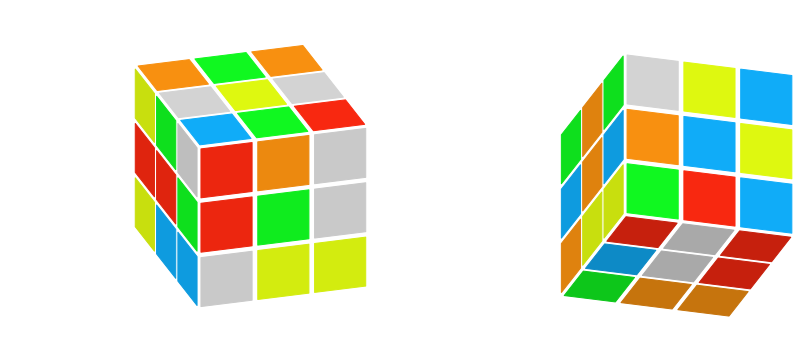

In [66]:
np.random.seed(0)
rc_1 = RubiksCube()
rc_1.visualise()

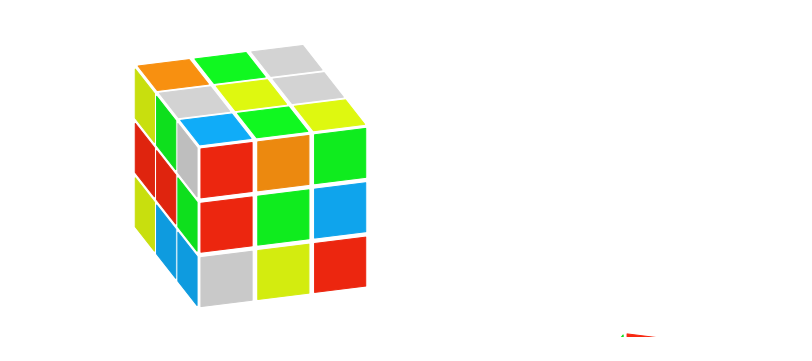

In [30]:
rc_1.make_move(Move('x', 2, 0.75))
rc_1.visualise()

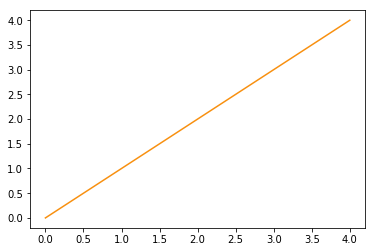

In [112]:
plt.plot(range(5), color=)